https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import quandl
quandl.ApiConfig.api_key = "vzYSmfRVEBUzvuAXxxZu"
%matplotlib inline

In [3]:
pd.__version__

'1.0.3'

In [5]:
# Se si vogliono aggiornare i dati
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
data.to_csv('btcusd.csv')

In [8]:
data = pd.read_csv(filepath_or_buffer="btcusd.csv", index_col="Date")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 2014-01-07 to 2020-03-28
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2273 non-null   float64
 1   High               2273 non-null   float64
 2   Low                2273 non-null   float64
 3   Close              2273 non-null   float64
 4   Volume (BTC)       2273 non-null   float64
 5   Volume (Currency)  2273 non-null   float64
 6   Weighted Price     2273 non-null   float64
dtypes: float64(7)
memory usage: 142.1+ KB


In [10]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [11]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [12]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True) #ffill riempe il nan con il valore del giorno successivo

In [13]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

In [14]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [17]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1591 682


In [18]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [29]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1586
677


In [30]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

 - 0s 164us/sample - loss: 0.0055 - val_loss: 0.0121
Epoch 118/300
1586/1586 [==============================] - 0s 164us/sample - loss: 0.0059 - val_loss: 0.0116
Epoch 119/300
1586/1586 [==============================] - 0s 159us/sample - loss: 0.0053 - val_loss: 0.0140
Epoch 120/300
1586/1586 [==============================] - 0s 179us/sample - loss: 0.0064 - val_loss: 0.0112
Epoch 121/300
1586/1586 [==============================] - 0s 162us/sample - loss: 0.0055 - val_loss: 0.0142
Epoch 122/300
1586/1586 [==============================] - 0s 164us/sample - loss: 0.0077 - val_loss: 0.0115
Epoch 123/300
1586/1586 [==============================] - 0s 158us/sample - loss: 0.0057 - val_loss: 0.0122
Epoch 124/300
1586/1586 [==============================] - 0s 165us/sample - loss: 0.0062 - val_loss: 0.0112
Epoch 125/300
1586/1586 [==============================] - 0s 163us/sample - loss: 0.0056 - val_loss: 0.0135
Epoch 126/300
1586/1586 [==============================] - 0s 157us/sample 

In [24]:
model.save('pred-btc-5day.h5')

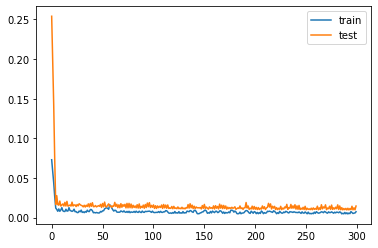

In [32]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

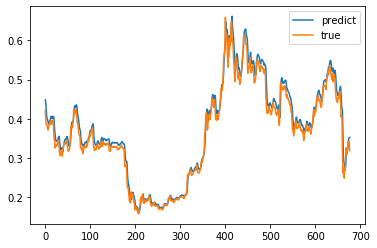

In [35]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [33]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

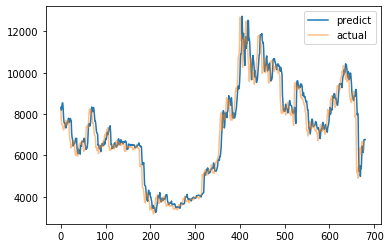

In [36]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [27]:
predictDates = data.tail(len(testX)).index

testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

##### Ricerca di feature correlate con il `weighted price`

Observation: Volume is corrlerated to Weighted Price.  Open, High, Low, Close are directly related to Weighted Price

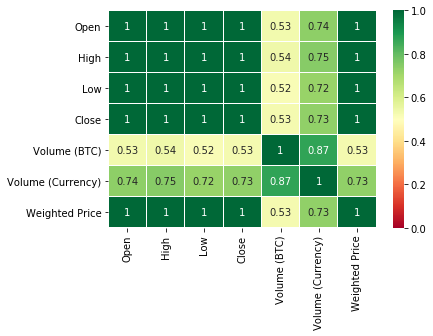

In [28]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)